Fastaiv3 Lesson 03, [head-pose](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-head-pose.ipynb)

## Overall Process

- Import data
- process data(matching with label)
    - each parent has callibration and needs to all coordination to calculate center point
- Databunch
    - PointItemList
    - Regression model(something which is continuous)
- show results

In [0]:
from fastai.vision import *

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

In [0]:
cal = np.genfromtxt(path/'18/rgb.cal', skip_footer=6)

In [33]:
cal

array([[505.265,   0.   , 320.   ],
       [  0.   , 505.265, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [16]:
[i for i in (path/'18').ls() if i.suffix == '.cal']

/root/.fastai/data/biwi_head_pose/18/rgb.cal
/root/.fastai/data/biwi_head_pose/18/depth.cal


[None, None]

In [34]:
fname = '18/frame_00265_rgb.jpg'

ERROR! Session/line number was not unique in database. History logging moved to new session 61


In [0]:
img2txt = lambda x: path/f'{str(x)[:-7]}pose.txt'

In [36]:
img2co(fname)

PosixPath('/root/.fastai/data/biwi_head_pose/18/frame_00265_pose.txt')

In [0]:
img = path/fname

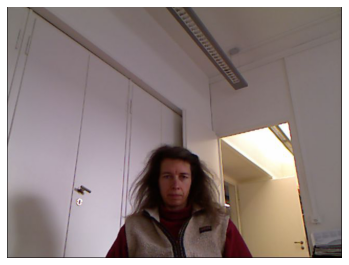

In [40]:
open_image(img).show(figsize=(6,6))

In [52]:
coords = np.genfromtxt(img2txt(img), skip_header=3); ctr ## coordinate

array([  39.734,  187.278, 1125.47 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1]) #y_first, so that c2 first

# get filename and return convert_biwi function
def get_center(fname):
    ctr = np.genfromtxt(img2txt(fname), skip_header=3)
    return convert_biwi(ctr)

In [53]:
ctr = get_center(fname); ctr

tensor([324.5760, 337.8380])

[ImagePoints](https://docs.fast.ai/vision.image.html#ImagePoints)

Support applying transforms to a flow of points.

Create an ImagePoints object from a flow of coordinates. Coordinates need to be scaled to the range (-1,1) which will be done in the intialization if scale is left as True. Convention is to have point coordinates in the form [y,x] unless y_first is set to False.


## Q. Why it says flow of points? It seems like do something when Transforming

In [0]:
def get_ip(img, ctr): return ImagePoints(FlowField(img.size, ctr), scale = True)

In [0]:
img_path = path/fname
img = open_image(img_path)

In [66]:
img.size

torch.Size([480, 640])

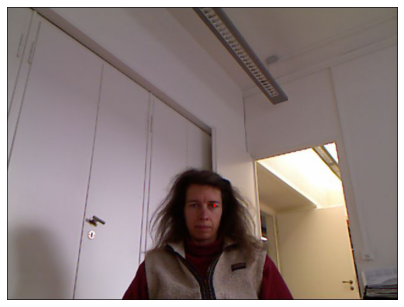

In [68]:
img.show(y=get_ip(img, ctr), figsize=(7,7))

## Q. why should i render `get_ip` function as y argument? don't know why...T.T

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda x: x.parent.name=='13')
        .label_from_func(get_center)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats))

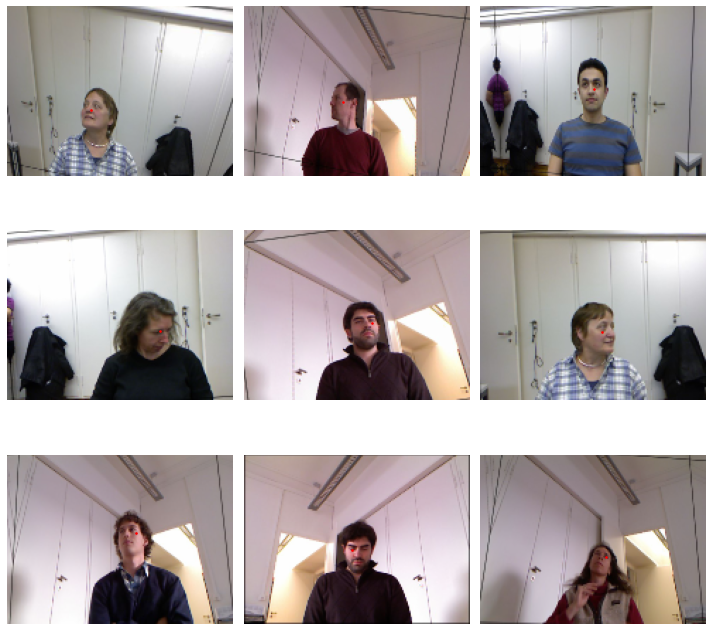

In [79]:
data.show_batch(3, figsize=(10,10))

In [83]:
learn = cnn_learner(data, models.resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [84]:
learn.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


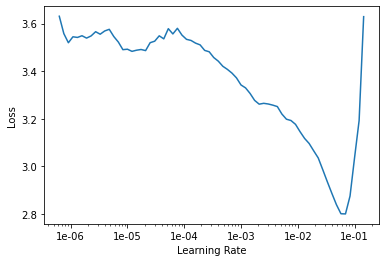

In [85]:
learn.lr_find()
learn.recorder.plot()

In [87]:
lr = 1e-03
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,time
0,1.159658,0.054299,02:46
1,0.116480,0.008102,02:46
2,0.034653,0.004287,02:47
